In [ ]:
# This notebook is to make Figure 1 of Rodgers et al. 2021 (https://doi.org/10.5194/esd-2021-50). 
# If you have have any questions, please contact the author of this notebook.
# Author: Ryohei Yamaguchi (ryamaguchi  at  pusan.ac.kr)

In [1]:
## The mpirun command:
## mpirun --np 6 dask-mpi --scheduler-file scheduler.json --no-nanny --dashboard-address :8785 --memory-limit=60e9
from dask.distributed import Client
client = Client(scheduler_file='/proj/ryamaguchi/Dask/run_2/scheduler.json')
client

Client Scheduler: tcp://203.247.189.225:37434 Dashboard: http://203.247.189.225:8786/status,Cluster Workers: 5 Cores: 90 Memory: 300.00 GB


### Import

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import glob
import os 

from datetime import datetime
today = datetime.today()

from tqdm.notebook import tqdm_notebook

### Read

In [3]:
VAR = ['FLNT','FSNT','PRECT','TREFHT','NPP','NBP']

scenarios=('HIST','SSP370')
members_cmip=('1001.001','1021.002','1041.003','1061.004','1081.005','1101.006','1121.007','1141.008','1161.009','1181.010',
              '1231.001','1231.002','1231.003','1231.004','1231.005','1231.006','1231.007','1231.008','1231.009','1231.010',
              '1251.001','1251.002','1251.003','1251.004','1251.005','1251.006','1251.007','1251.008','1251.009','1251.010',
              '1281.001','1281.002','1281.003','1281.004','1281.005','1281.006','1281.007','1281.008','1281.009','1281.010',
              '1301.001','1301.002','1301.003','1301.004','1301.005','1301.006','1301.007','1301.008','1301.009','1301.010')
members_smbb=('1011.001','1031.002','1051.003','1071.004','1091.005','1111.006','1131.007','1151.008','1171.009','1191.010',
              '1231.011','1231.012','1231.013','1231.014','1231.015','1231.016','1231.017','1231.018','1231.019','1231.020',
              '1251.011','1251.012','1251.013','1251.014','1251.015','1251.016','1251.017','1251.018','1251.019','1251.020',
              '1281.011','1281.012','1281.013','1281.014','1281.015','1281.016','1281.017','1281.018','1281.019','1281.020',
              '1301.011','1301.012','1301.013','1301.014','1301.015','1301.016','1301.017','1301.018','1301.019','1301.020')
members=members_cmip+members_smbb
ensembles = [ens for ens in range(len(members))]

In [4]:
exceptcv=['time','lon','lat','area','landfrac',*VAR]
def process_coords(ds, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
          
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [6]:
time='month_1'

file_list=[]
for var in VAR :
    ens_files=[]
    for member in members :
        files=[]    
        for scenario in scenarios :
            comp,model='atm','cam.h0'
            if var=='NBP' or var=='NPP': comp,model='lnd','clm2.h0'
                
            in_dir = '/proj/jedwards/archive/b.e21.B'+scenario+'*.f09_g17.LE2-'+member+'/'+comp+'/proc/tseries/'+time+'/'
            
            fn = 'b.e21.B'+scenario+'*.f09_g17.LE2-'+member+'.'+model+'.'+var+'.*.nc'
            files += glob.glob(in_dir+fn)
            files = sorted(files)
        ens_files.append(files)
    file_list.append(ens_files) 
for i in range(len(VAR)):
    print(i,VAR[i],len(file_list[i]),len(file_list[i][-1]))

0 FLNT 100 26
1 FSNT 100 26
2 PRECT 100 26
3 TREFHT 100 26
4 NPP 100 26
5 NBP 100 26


In [7]:
ds_0=xr.open_mfdataset(file_list[0],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_1=xr.open_mfdataset(file_list[1],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_2=xr.open_mfdataset(file_list[2],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_3=xr.open_mfdataset(file_list[3],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_4=xr.open_mfdataset(file_list[4],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_5=xr.open_mfdataset(file_list[5],chunks={'time':120},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)

In [8]:
time_new=xr.cftime_range(start='1850',end='2101',freq='1M',calendar='noleap')
ds_0=ds_0.assign_coords(time=time_new)
ds_1=ds_1.assign_coords(time=time_new)
ds_2=ds_2.assign_coords(time=time_new)
ds_3=ds_3.assign_coords(time=time_new)
ds_4=ds_4.assign_coords(time=time_new)
ds_5=ds_5.assign_coords(time=time_new)

### Time series (atm)

In [9]:
ts_0_gl = ds_0[VAR[0]].weighted(xr.ufuncs.cos(np.deg2rad(ds_0.lat))).mean(('lon','lat'),skipna=True).load()
ts_1_gl = ds_1[VAR[1]].weighted(xr.ufuncs.cos(np.deg2rad(ds_1.lat))).mean(('lon','lat'),skipna=True).load()
ts_2_gl = ds_2[VAR[2]].weighted(xr.ufuncs.cos(np.deg2rad(ds_2.lat))).mean(('lon','lat'),skipna=True).load()
ts_3_gl = ds_3[VAR[3]].weighted(xr.ufuncs.cos(np.deg2rad(ds_3.lat))).mean(('lon','lat'),skipna=True).load()

### Time series (lnd)

<xarray.DataArray (lat: 192, lon: 288)>
array([[2.9945992e+07, 2.9945992e+07, 2.9945992e+07, ..., 2.9945992e+07,
        2.9945992e+07, 2.9945992e+07],
       [2.3955581e+08, 2.3955581e+08, 2.3955581e+08, ..., 2.3955581e+08,
        2.3955581e+08, 2.3955581e+08],
       [4.7904682e+08, 4.7904682e+08, 4.7904682e+08, ..., 4.7904682e+08,
        4.7904682e+08, 4.7904682e+08],
       ...,
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0

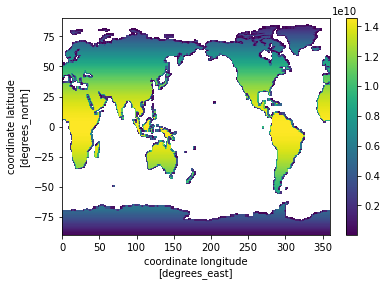

In [10]:
area_land=ds_4.area.isel(concat_dim=0,time=0).drop(('concat_dim','time'))*ds_4.landfrac.isel(concat_dim=0,time=0).drop(('concat_dim','time'))
area_land=(area_land*1e6).load()
area_land.plot()
area_land

In [11]:
ts_4_gl = (ds_4[VAR[4]]*area_land).sum(('lon','lat'),skipna=True).load()
ts_5_gl = (ds_5[VAR[5]]*area_land).sum(('lon','lat'),skipna=True).load()

### Write

In [18]:
print(VAR[0],ds_0[VAR[0]].units)
print(VAR[1],ds_1[VAR[1]].units)
print(VAR[2],ds_2[VAR[2]].units)
print(VAR[3],ds_3[VAR[3]].units)
print(VAR[4],ds_4[VAR[4]].units,'1e6',ds_4.area.units)
print(VAR[5],ds_5[VAR[5]].units,'1e6',ds_5.area.units)

FLNT W/m2
FSNT W/m2
PRECT m/s
TREFHT K
NPP gC/m^2/s 1e6 km^2
NBP gC/m^2/s 1e6 km^2


In [19]:
paths=[]
for i in range(6):
    if i==0 : ds,da_w,calc,unit=ds_0,ts_0_gl,'averaged',ds_0[VAR[i]].units
    if i==1 : ds,da_w,calc,unit=ds_1,ts_1_gl,'averaged',ds_1[VAR[i]].units
    if i==2 : ds,da_w,calc,unit=ds_2,ts_2_gl,'averaged',ds_2[VAR[i]].units
    if i==3 : ds,da_w,calc,unit=ds_3,ts_3_gl,'averaged',ds_3[VAR[i]].units
    if i==4 : ds,da_w,calc,unit=ds_4,ts_4_gl,'integrated','gC s-1'
    if i==5 : ds,da_w,calc,unit=ds_5,ts_5_gl,'integrated','gC s-1'

    vname=VAR[i]
    out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/'
    fn=today.strftime("%y%m%d")+'_global.'+VAR[i]+'.%s-members.nc' %len(members)

    da_w.name=vname
    ds_w=da_w.to_dataset()
    ds_w=ds_w.rename({'concat_dim':'ensemble'})
    ds_w=ds_w.assign_coords(ensemble=[*members])
    ds_w[vname].attrs['units']        = unit
    ds_w[vname].attrs['long_name']    = "Global-%s %s" %(calc,VAR[i])
#    ds_w[vname].attrs['_FillValue']   = ds[VAR[i]].encoding['_FillValue']
#    ds_w[vname].attrs['missing_value']= ds[VAR[i]].encoding['missing_value']
    ds_w.attrs['history']="%s members, script path: %s, made by ryamaguchi" %(len(members),os.getcwd())

    ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
    paths+=[out_dir+fn]